pouzite kniznice so far:
pandas ,scikit-learn, torch

Task 1 - Data analysis:
(potrobnejšie info o data sete máme z https://www.kaggle.com/datasets/uciml/faulty-steel-plates )
Prvne sme zanalizovali veľkosť našeho data setu. Má 1941 položiek pričom každá položka má 34 stĺpcov.

Pokiaľ si zobereme čo aký stĺpec znamená, tak prvých 27 mi určuje parametre položky (v našom prípade sa jedná o Oceľové Pláty). Parametre sú celočíeslne (14 stĺpcov) alebo reálne (13. stĺpcov) hodnoty. Niektoré tieto parametre sú napríklad:

X_Minimum
X_Maximum
Y_Minimum
Y_Maximum
Pixels_Areas
X_Perimeter
Y_Perimeter
Sum_of_Luminosity
Minimum_of_Luminosity ...

Posledných 7 stĺpcov nám určuje či daná položka ma nejakú vadu. Prvých 6 je nejaká konkrétna vada a posledná nam určuje či položka je vadná (0) alebo nie (1). Tieto stĺpce máju boolovsku hodnotu (čiže 0 alebo 1). Pričom 0 znamená, že daná položka nemá túto vadu a 1 zase znamená, že túto vadu obsahuje. Možné vady sú:

    Pastry
    Z_Scratch
    K_Scatch
    Stains
    Dirtiness
    Bumps

Data set neobsahuje žiadne chýbajúce hodnoty.

In [20]:
import pandas as pd

df = pd.read_csv("faults.csv")
print(df.shape)

print("Mame chybajuce hodnoty?")
print(df.isna().sum().sum())
print("Mame duplikaty?")
print(df.duplicated().sum())


(1941, 34)
Mame chybajuce hodnoty?
0
Mame duplikaty?
0


Data preprocessing, Normalization and Data Split

Keďže nemáme chýbajúce hodnoty ani duplikátne hodnoty môžeme ísť rovno k ďaľším krokom. Zistíme si koreláciu medzi dátami v našom data sete pomocou "Heatmap". Najrpv medzi vstupnými dátami, kde vidíme, že medzi niektorími vstupnými dátami je vysoká priama korelácia, to znaméná že narastajú vzájomne lineárne a neskôr do MLPčka by nepridávali žiadne nové dáta.





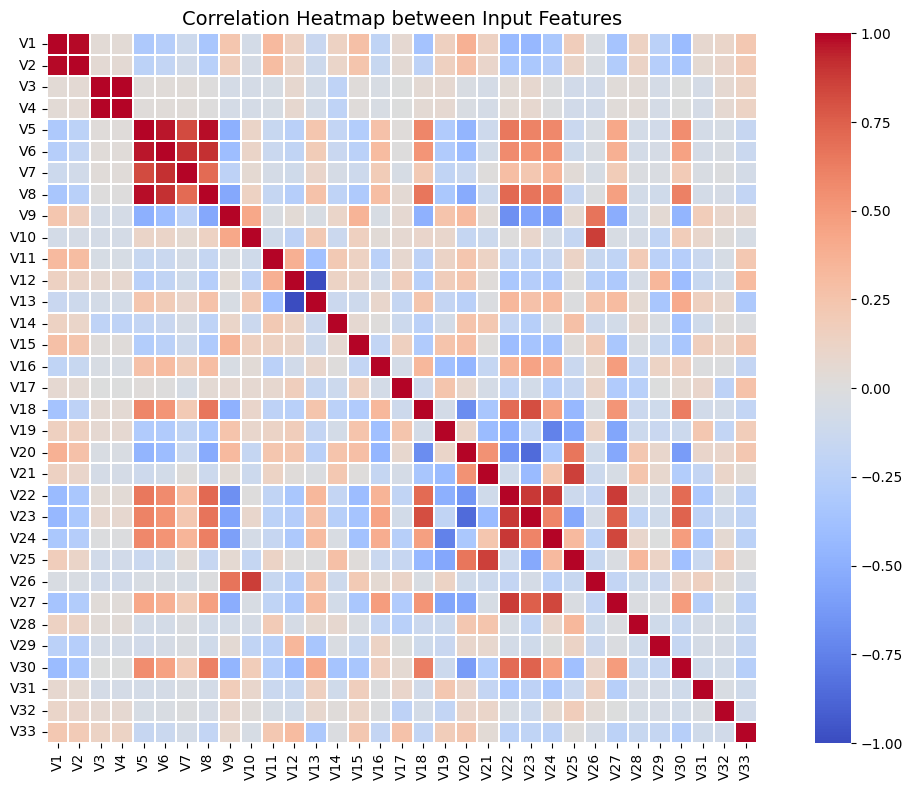

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("faults.csv")
input_df = df.select_dtypes(include=["number"]).drop(columns=["Class"], errors="ignore")
corr = input_df.corr(numeric_only=True)
plt.figure(figsize=(12, 8))
sns.heatmap(
    corr,
    cmap="coolwarm",
    annot=False,
    linewidths=0.3,
    square=True
)
plt.title("Correlation Heatmap between Input Features", fontsize=14)
plt.tight_layout()
plt.show()

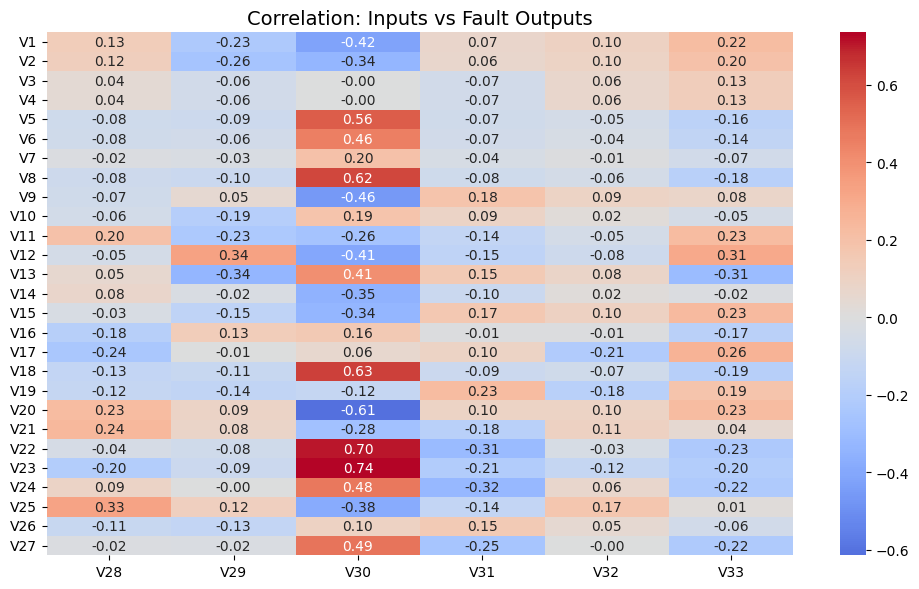

In [22]:
fault_columns = ['V28', 'V29', 'V30', 'V31', 'V32', 'V33']
input_cols = [c for c in df.columns if c not in fault_columns + ['Class']]

corr_io = df[input_cols + fault_columns].corr(numeric_only=True)
plt.figure(figsize=(10, 6))
sns.heatmap(
    corr_io.loc[input_cols, fault_columns],
    cmap="coolwarm",
    annot=True,
    fmt=".2f",
    center=0
)
plt.title("Correlation: Inputs vs Fault Outputs", fontsize=14)
plt.tight_layout()
plt.show()
